# Trajectory Planning 
Computing the trajectory for a holonomic robot using polynomial functions. We obtain the desired trajectory by first using a polynomial of degree 4, and then as a fifth degree Bernstein polynomial. 

Let's get started then!

As usual, we first import the required libraries.

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

These functions give the output of our 4 variable polynomial for a value of t

In [87]:
def gen_output_t(a, t):
    final = []
    for t_val in t:
        total = 0
        for i in range(len(a)):
            temp = a[i] * (t_val**i)
            total += temp
        final.append(total)
    return final

def differentiate_a(a):
    a_new = [a[i] * i for i in range(len(a))]
    return a_new[1:]

## Formulating Ma = b 

In [88]:
tf = 5
tc = 2  
t0 = 0
# M array is constant across both x and y

In [89]:
x0 = 3
y0 = 0
xf = 9
yf = 5
x_cookie = 1
y_cookie = 2.5

x0_vel = 0
y0_vel = 0
xf_vel = 0
yf_vel = 0

- The first row is x[t] for t = t0, when he starts
- The second row is x_vel[t] for t = t0
- The third row is x[t] for t = tf, when he finds his friend
- The fourth row is x_vel[t] for t = tf
- The fifth row is x[t] for t = tc, when he finds the cookie. 

In [90]:
M = [   [1, t0,    t0**2, t0**3,   t0**4],
        [0, 1,     2*t0,  3*t0**2, 4*t0**3],
        [1, tf**1, tf**2, tf**3,   tf**4],
        [0, 1,     2*tf,  3*tf**2, 4*tf**3],
        [1, tc,    tc**2, tc**3,   tc**4]
    ]
M = np.array(M)

# Constraints in x and y
bx = np.array([x0, x0_vel, xf, xf_vel, x_cookie])
by = np.array([y0, y0_vel, yf, yf_vel, y_cookie])

In [91]:
# To solve equation in the form M * a = b
Minv = np.linalg.inv(M)
ax = Minv @ bx
ay = Minv @ by

Getting (x,y) for each t. 

In [125]:
time = np.arange(0, 5.5, 0.1).tolist()
x = gen_output_t(ax, time)
y = gen_output_t(ay, time)

Defining the three known points:

## Plotting the trajectory

In [126]:
def plot(x,y):
    plt.figure()
    plt.plot(x0,y0, 'ro')
    plt.plot(xf,yf, 'ro')
    plt.plot(x_cookie,y_cookie, 'ro')
    plt.plot(x,y)
    plt.show()

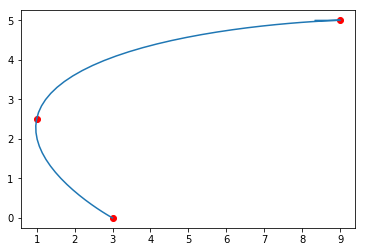

In [127]:
plot(x,y)

In [128]:
diff_ax = differentiate_a(ax)
diff_ay = differentiate_a(ay)
x_vel = gen_output_t(diff_ax, time)
y_vel = gen_output_t(diff_ay, time)

### Plotting velocity and acceleration

In [148]:
def plot2(x,y, x_vel, y_vel):
    
    plt.figure()
    figure(figsize=(20, 10))

    plt.subplot(221)
    plt.title("X position vs Time")
    plt.plot(time, x)

    plt.subplot(222)
    plt.title("Y position vs Time")
    plt.plot(time, y)

    plt.subplot(223)
    plt.title("X velocity vs Time")
    plt.plot(time, x_vel) 

    plt.subplot(224)
    plt.title("Y velocity vs Time")
    plt.plot(time, y_vel) 

<Figure size 432x288 with 0 Axes>

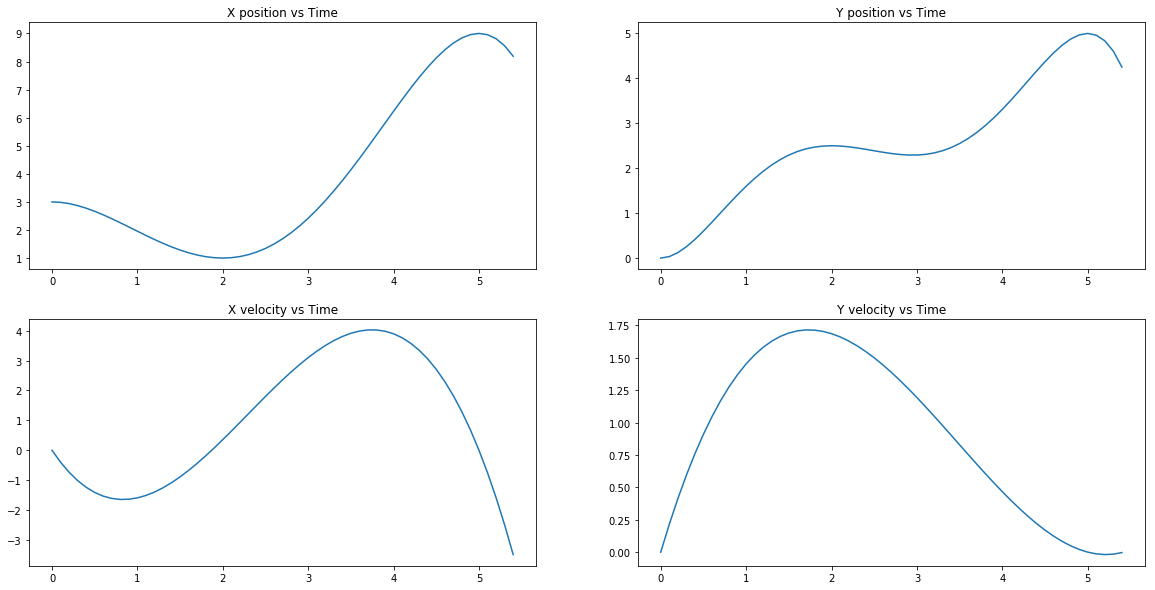

In [149]:
plot2(x,y, x_vel, y_vel)

## Bernstein Polynomial

Functions calculating nCr and factorial

In [166]:
def nCr(n, r): 
    return (fact(n) / (fact(r)  * fact(n - r))) 
  
def fact(n): 
    res = 1
    for i in range(2, n+1): 
        res = res * i 
    return res 

Reference: http://graphics.cs.ucdavis.edu/education/CAGDNotes/Bernstein-Polynomials.pdf \
Similar Reference: https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.897.2894&rep=rep1&type=pdf 

In [167]:
def calc_bernstein(i, j, n):
    temp = (-1) ** (i-j)
    return temp * nCr(n, i) * nCr(i, j)

def make_bern(n):
    mat = []
    for i in range(n+1):
        temp = []
        for j in range(n+1):
            if i<j:
                temp.append(0)
            else:
                temp.append(calc_bernstein(i, j, n))
        mat.append(temp)
    return np.array(mat)

B(t) = [1 t t^2...t^n] * make_bern(n) * [c0 c1 c2...cn] = [b0 b1 b2..bn]

In [168]:
poly = make_bern(5)
def eval_pos(poly, t):
    temp = []
    for i in range(len(poly)):
        val = 0
        for j in range(len(poly)):
            val += poly[j][i] * t **j
        temp.append(val)
    return temp

- Computing velocity constraints

In [169]:
def eval_vel(poly, t):
    temp = []
    for i in range(len(poly)):
        val = 0
        for j in range(len(poly)):
            if j-1 < 0:
                val += 0
            else: 
                val += j * poly[j][i] * t **(j-1)
        temp.append(val)
    return temp

- Computing acceleration constraints

In [170]:
def eval_acc(poly, t):
    temp = []
    for i in range(len(poly)):
        val = 0
        for j in range(len(poly)):
            if j-2 < 0:
                val += 0
            else:
                val += j * (j-1) * poly[j][i] * t **(j-2)
        temp.append(val)
    return temp

In [185]:
# at time 0, coefficients?
M = []
bx = []
by = []

## Building the M matrix

- At time t=0, robot starts at (3,0). So we call eval_pos, which computes the position constraints. 

In [186]:
coefs1 = eval_pos(poly, t0)
M.append(coefs1)

- Now the robot picks up the cookie at (1,2.5) at t=2. 

In [187]:
coefs2 = eval_pos(poly, tc)
M.append(coefs2)

- And finally the robot reaches his friend at (9,5) at t = 5

In [188]:
coefs3 = eval_pos(poly, tf)
M.append(coefs3)

- So we have got three constraints each for x and y, all of which are related to position. 
- Now we compute velocity constraints. 
- The velocity of robot in both directions is (0,0) at t=0

In [189]:
coefs4 = eval_vel(poly, t0)
M.append(coefs4)

- And when it reaches his friend, it reaches with final velocity as (0,0) because it must not crash into his friend!

In [190]:
coefs5 = eval_vel(poly, tf)
M.append(coefs5)

- We add another constraint, saying that his velocity when he reaches the cookie must also be zero to avoid any possibility of a collision. 

In [191]:
x_cookie_vel = 0
y_cookie_vel = 0
coefs6 = eval_vel(poly, tc)
M.append(coefs6)

In [192]:
# Constraints in x and y 
bx = np.array([x0, x_cookie, xf, x0_vel, xf_vel, x_cookie_vel])
by = np.array([y0, y_cookie, yf, y0_vel, yf_vel, y_cookie_vel])

M = np.array(M)
bx = np.array(bx)
by = np.array(by)
cx = np.linalg.inv(M) @ bx.T
cy = np.linalg.inv(M) @ by.T

In [193]:
def output_pos(poly_5, c, t):
    return np.array(eval_pos(poly_5, t)) @ c.T

def output_vel(poly_5, c, t):
    return np.array(eval_vel(poly_5, t)) @ c.T

def output_acc(poly_5, c, t):
    return np.array(eval_acc(poly_5, t)) @ c.T

## Plotting the trajectory

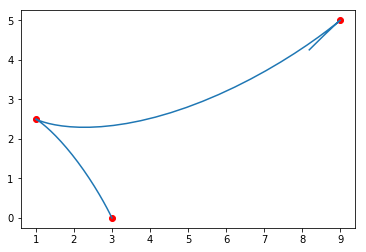

In [194]:
x = [output_pos(poly_5, cx, t) for t in time]
y = [output_pos(poly_5, cy, t) for t in time]

x_vel = [output_vel(poly_5, cx, t) for t in time]
y_vel = [output_vel(poly_5, cy, t) for t in time]

plot(x,y)

### Position, Velocity and Accelerations

<Figure size 432x288 with 0 Axes>

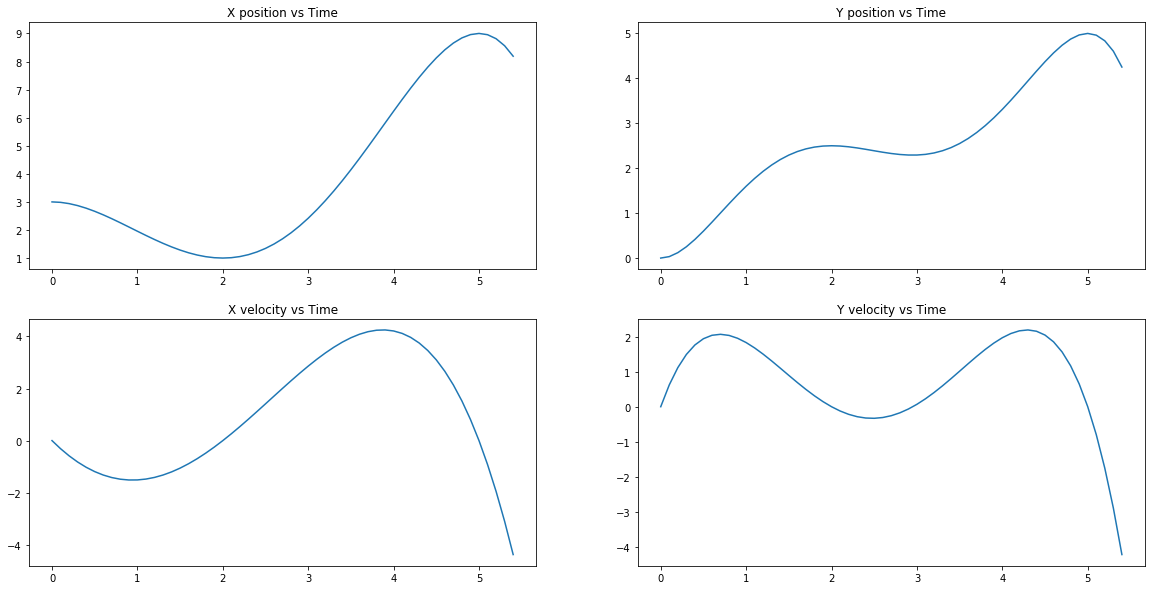

In [195]:
plot2(x,y, x_vel, y_vel)

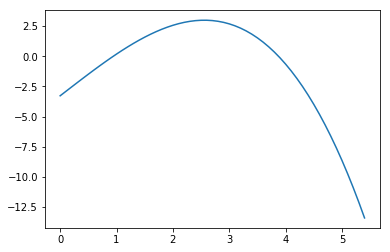

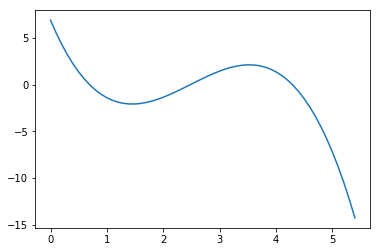

In [196]:
x = [output_acc(poly_5, cx, t) for t in time]
y = [output_acc(poly_5, cy, t) for t in time]
plt.plot(time, x) # Acc x
plt.show()
plt.plot(time, y) # Acc y
plt.show()

## Evil Robot 


An evil robot of radius 2 units appears at (5, 4) to steal his cookie. The robot, whose radius is 1 unit, must avoid this evil robot in order to successfully deliver the cookie. \
We assume 4 more constraints, to avoid collision with the evil robot. 